### Building LLAMA using pytorch 


##### Major differences wrt GPT

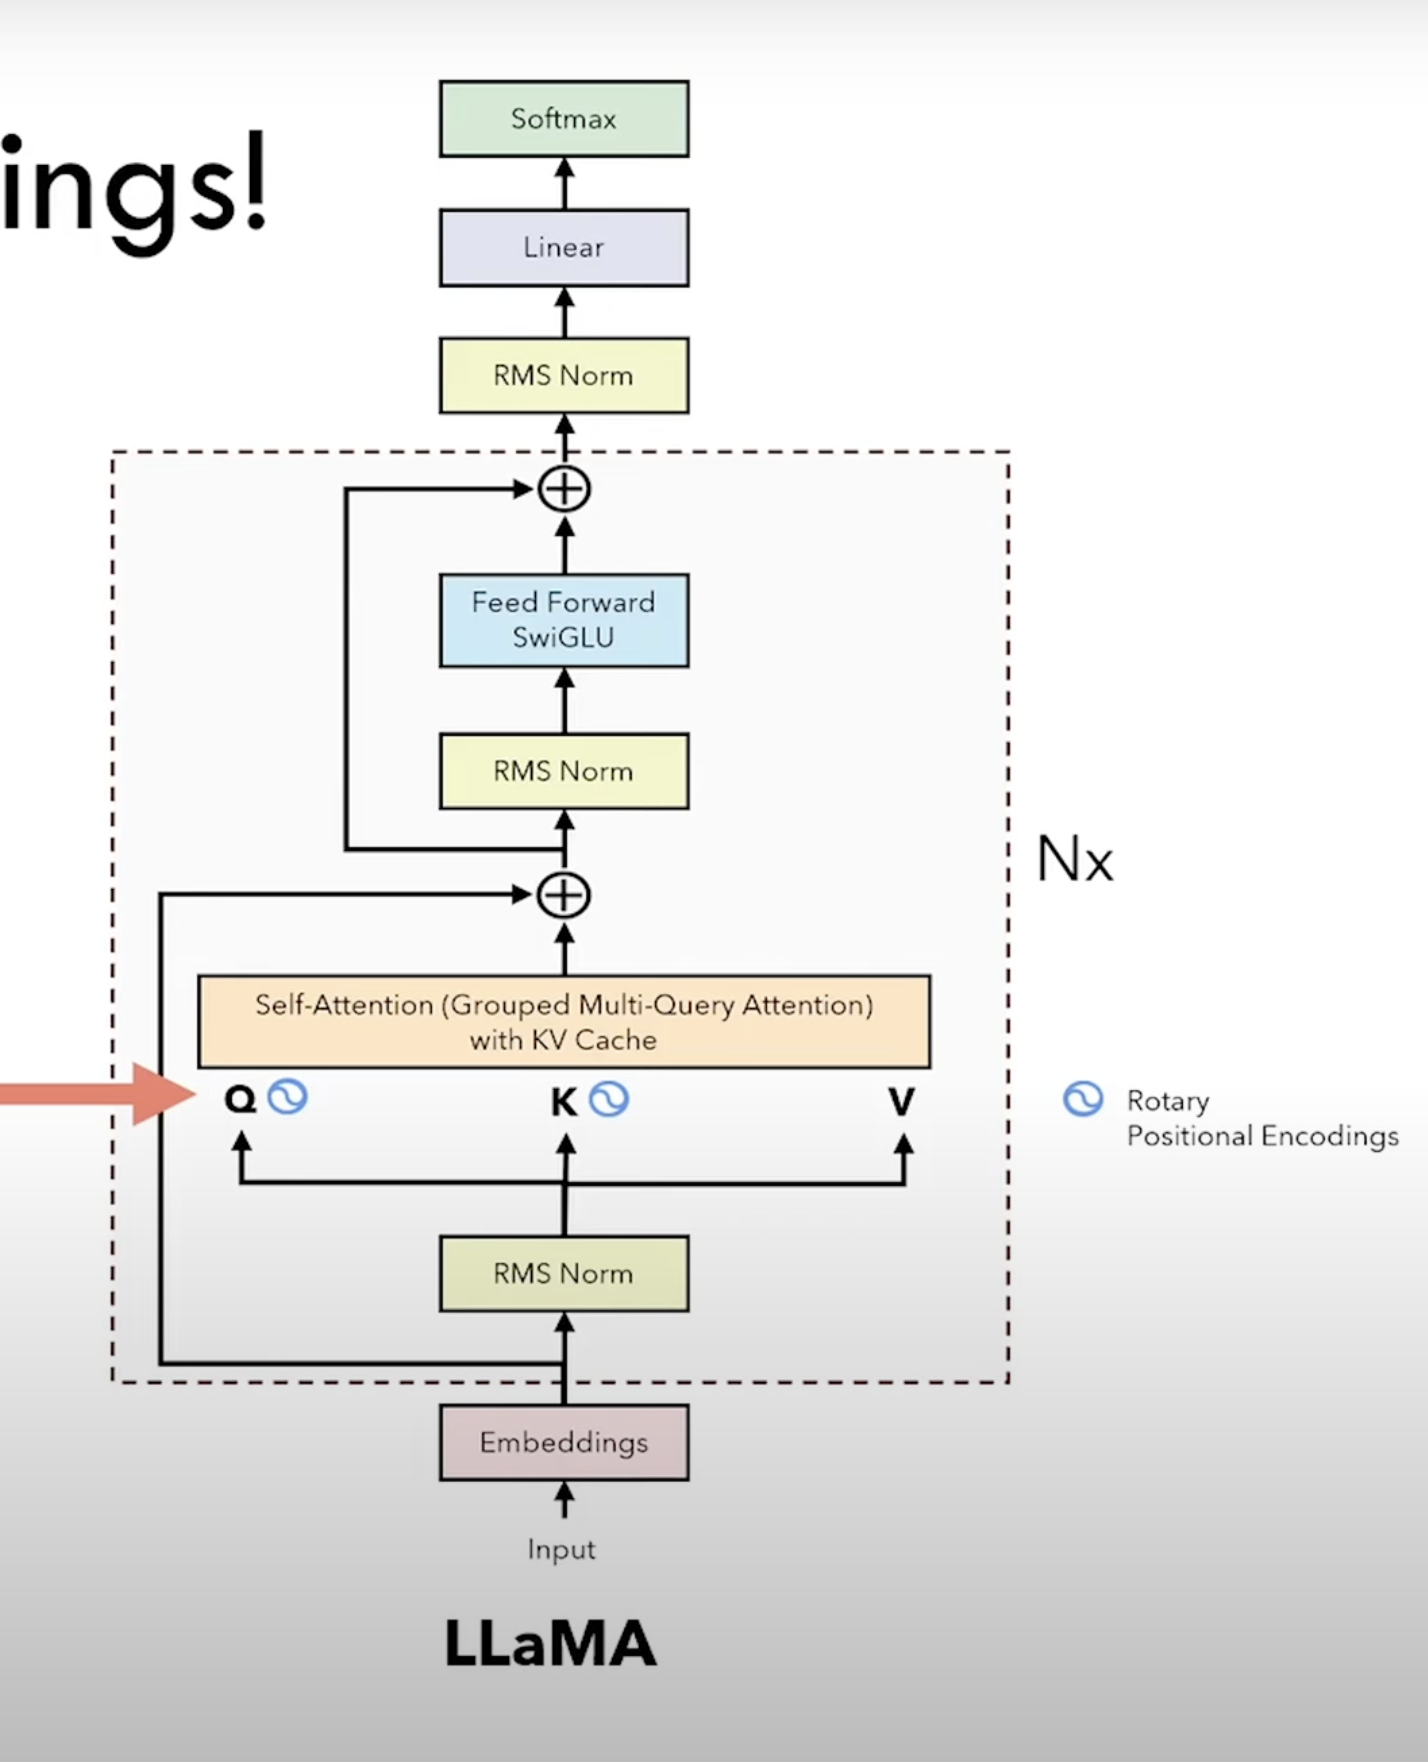

source: Umar Jamil


- **RMSNorm**: LLaMA uses Root Mean Square Layer Normalization (RMSNorm) instead of the standard LayerNorm used in Transformers and GPT. RMSNorm is simpler and computationally cheaper, as it normalizes based on the root mean square of the input, avoiding the need to compute mean and variance

- **SwiGLU Activation**: Instead of the ReLU or GELU activations used in GPT, LLaMA employs SwiGLU (a variant of the Swish activation combined with Gated Linear Units), which improves performance by allowing the model to learn more complex patterns.

- **Rotary Positional Embeddings (RoPE)**: Unlike absolute positional encodings (used in early Transformers) or learned positional embeddings (used in GPT), LLaMA uses Rotary Positional Embeddings. RoPE applies a rotation matrix to the query and key vectors in attention, encoding relative positions more effectively and reducing memory usage.



In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math, time
from dataclasses import dataclass
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [113]:
@dataclass
class ModelConfig:
    d_model = 128
    seq_len = 32
    batch_size = 2
    n_blocks = 6
    q_heads = 8
    kv_heads = 4
    ffn_multiplier = None
    ffn_muliple_of = 32
    vocab_size = 64 # set later
    eps = 1e-6

config = ModelConfig()

In [114]:
## load data and tokenize
data_path = "../data/hp_book1.txt"
txt = open(data_path).read()
chars = sorted(list(set(txt)))
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}
tokenizer = stoi

# train-val 
encode = lambda x: [tokenizer[i] for i in x]
decode = lambda x: ''.join( [itos[i] for i in x] )
data = torch.tensor(encode(txt), dtype=torch.long)

In [115]:
config.vocab_size = len(tokenizer)
config.tokenizer = tokenizer

In [116]:
train = data[:int( len(txt)*0.9 ) ] 
val = data[int( len(txt)*0.9 ): ]

def get_batch_data(mode):
    data = train if mode == 'train' else val
    idx = torch.randint( len(data) - config.seq_len, (config.batch_size,) )
    
    x = torch.stack( [ data[i:i+config.seq_len] for i in idx] )
    y = torch.stack( [ data[i+1:i+config.seq_len+1] for i in idx] )
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x,y 

x, y = get_batch_data(mode='train')

In [117]:
class RMSNorm(nn.Module):
    """
    Refer formula; shape in - shape out
    1. calculate rms_norm 
    2. x * rms_norm * gain
    """
    def __init__(self, config):
        super().__init__()
        self.eps = config.eps
        self.gain = nn.Parameter(torch.ones(config.d_model)) # gain param like gamma in layerNorm
    
    def _norm(self, x):
        """
        RMS norm across emb dim/ feature layer
        """
        rms = torch.rsqrt( torch.mean(x**2, dim=-1, keepdim=True) + self.eps ) # 1/sqrt
        x_norm = x * rms
        return x_norm

    def forward(self, x):
        x_norm = self._norm(x.float()).type_as(x) # from any mixed precision to high precision float
        return self.gain * x_norm

test = torch.randn((2, 4, 128))
rms = RMSNorm(config=config)
rms(test).shape

torch.Size([2, 4, 128])

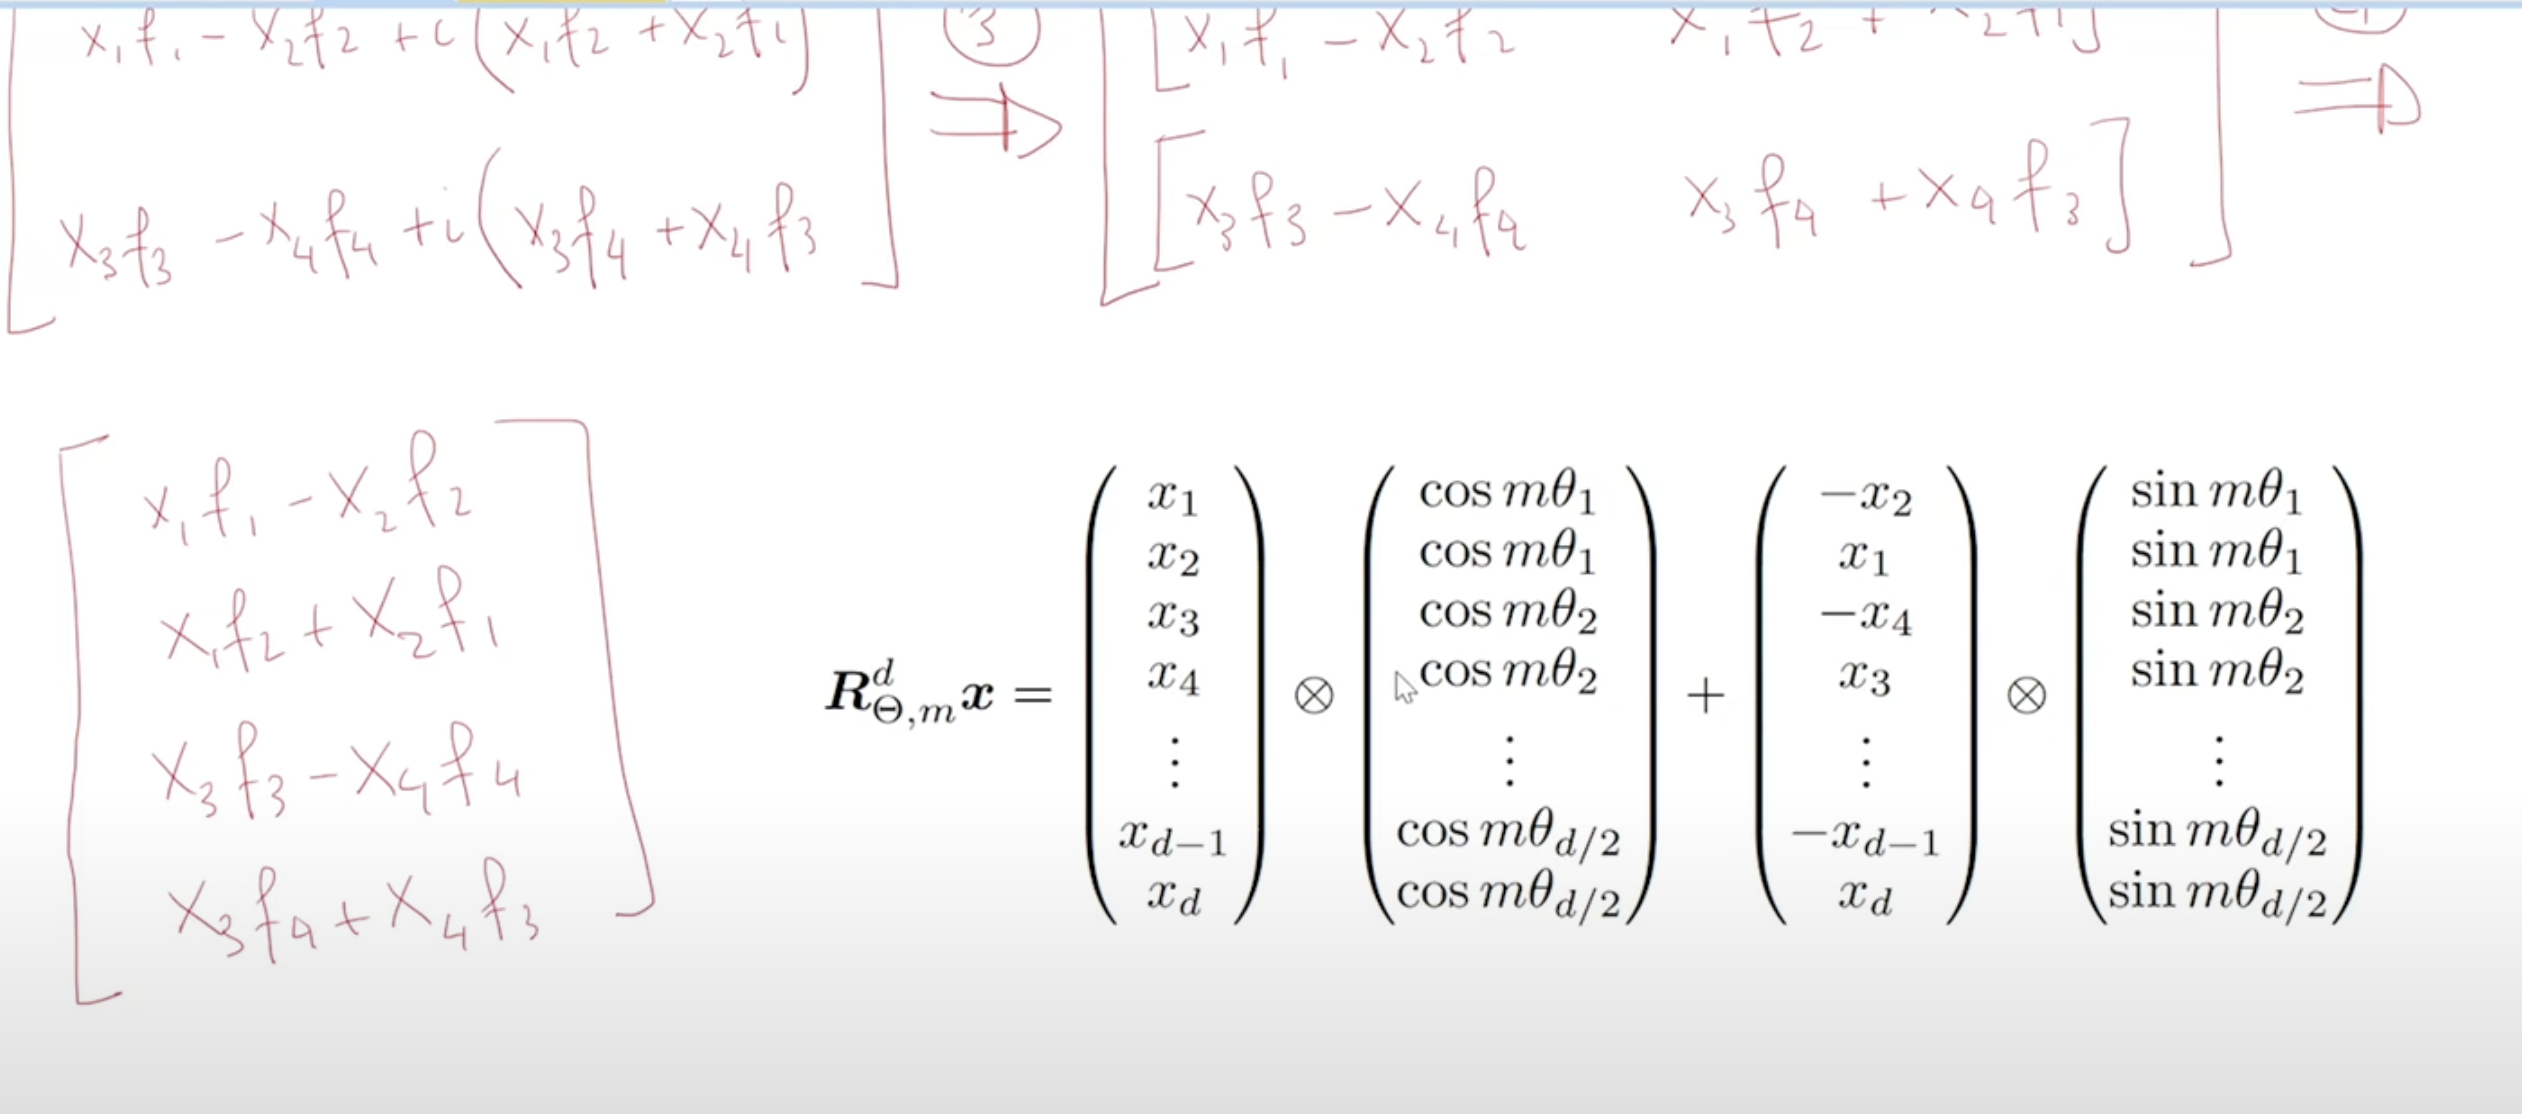

source: Umar Jamil

In [118]:
def precompute_freqs_cis(head_dim, seq_len, theta: float = 10000.0):
    """
    precompute rope freqs for all possible value of m-theta to multiple with 
    q and k 
    """
    assert head_dim % 2 == 0, "head_dim must be divisible by 2"

    theta_numerator = torch.arange(0, head_dim, 2).float()
    freqs = 1.0 / (theta ** (theta_numerator / head_dim )).to(DEVICE)
    m = torch.arange(seq_len, device=DEVICE)
    freqs = torch.outer(m, freqs).float()

    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

def apply_rotary_emb(q: torch.Tensor, k: torch.Tensor, freqs: torch.Tensor):
    ## convert to pair of numbers for complex number representation
    q_cmplx = torch.view_as_complex( q.float().reshape(*q.shape[:-1], -1, 2 ) )
    k_cmplx = torch.view_as_complex( k.float().reshape(*k.shape[:-1], -1, 2 ) )
    ## add fake batch and heads
    freqs = freqs.unsqueeze(0).unsqueeze(2)                                   # (seq_len, head_dim/ 2) -> (1, seq_len, 1, head_dim/ 2)
    ## view as real and reshape to original
    q_rotated = torch.view_as_real(q_cmplx * freqs).reshape(*q.shape)
    k_rotated = torch.view_as_real(k_cmplx * freqs).reshape(*k.shape)
    return q_rotated, k_rotated

pre_f = precompute_freqs_cis(config.d_model // config.q_heads, config.seq_len)
q_test = torch.randn( (8, 16) ).view(1, 1, 8, 16)
k_test = torch.randn( (4, 16) ).view(1, 1, 4, 16)

apply_rotary_emb(q_test, k_test, pre_f[:1])[0].shape

torch.Size([1, 1, 8, 16])

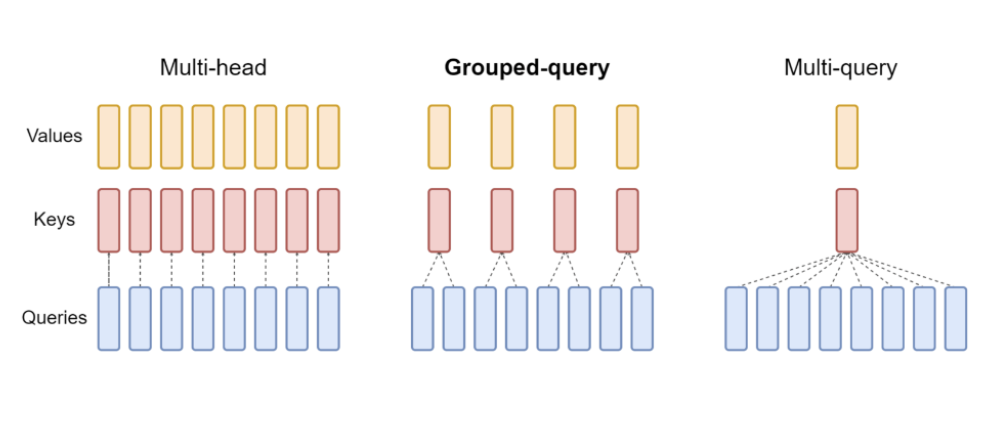


In [119]:
class GQA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.q_heads = config.q_heads
        self.kv_heads = config.kv_heads
        self.head_dim = config.d_model // self.q_heads
        self.n_groups = self.q_heads // self.kv_heads

        self.q_proj =  nn.Linear(config.d_model, self.q_heads * self.head_dim , bias=False)
        self.k_proj =  nn.Linear(config.d_model, self.kv_heads * self.head_dim, bias=False)
        self.v_proj =  nn.Linear(config.d_model, self.kv_heads * self.head_dim, bias=False)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.freqs_cis = precompute_freqs_cis(self.head_dim, self.seq_len)
        
        self.register_buffer('trill', torch.tril(torch.ones((config.seq_len, config.seq_len))), persistent=False)
        self.k_cache = None
        self.v_cache = None

    def forward(self, x, step=None):
        B, T, C = x.shape
        # q(x)       -> B T C -> B T C
        # k(x), v(x) -> B T C -> B T (C// self.n_groups)
        # split C -> n_heads * heads_dim
        q, k, v = (
            self.q_proj(x).reshape( B, T, self.q_heads, self.head_dim ),
            self.k_proj(x).reshape( B, T, self.kv_heads, self.head_dim ),
            self.v_proj(x).reshape( B, T, self.kv_heads, self.head_dim ),
        )
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T])

        ## use kv cache
        if step is not None:
            if self.k_cache is None:
                self.k_cache = torch.zeros(B, self.seq_len, self.kv_heads, self.head_dim, device=x.device)
                self.v_cache = torch.zeros(B, self.seq_len, self.kv_heads, self.head_dim, device=x.device)

            self.k_cache[:, step:step+T] = k
            self.v_cache[:, step:step+T] = v
            k = self.k_cache[:, :step+T]
            v = self.v_cache[:, :step+T]

        # since C of k and v is less, repeat in heads dim.
        k = k.repeat_interleave(self.n_groups, dim=2)
        v = v.repeat_interleave(self.n_groups, dim=2)

        ## swap head and T
        q, k, v = q.transpose(1,2), k.transpose(1,2), v.transpose(1,2)

        ## causal attn
        attn = ( q @ k.transpose(-2,-1) ) * (self.head_dim ** -0.5)
        if step is None:
            attn = attn.masked_fill(self.trill[:T, :T] == 0, float("-inf"))
        else:
            mask = self.trill[:attn.size(-2), :attn.size(-1)].to(x.device)
            attn = attn.masked_fill(mask == 0, float("-inf"))

        attn = F.softmax(attn, dim=-1)
        out = attn @ v
        
        # swap H, T and then back to B T C
        out = out.transpose(1, 2).reshape(B, T, C)
        return self.out_proj(out)

x = torch.rand( 2, 8, 128 )
gqa = GQA(config=config)
gqa(x).shape

torch.Size([2, 8, 128])

* LLaMA replaces the usual Transformer FFN’s **GELU** with a **SwiGLU** (Swish-Gated Linear Unit).
* Standard Transformer FFN:

$$
\text{FFN}(x) = W_2 \, \text{activation}(W_1 x) 
$$

* SwiGLU variation:

$$
\text{FFN}(x) = W_2 \, [\text{Swish}(W_1 x) \odot (W_3 x)]
$$

* `W1` → produces the **activation branch**.
* `W3` → produces the **gate branch**.
* Swish = `x * sigmoid(x)` (PyTorch’s `F.silu`).
* Elementwise multiply (`*`) gates one branch with the other.

In [120]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        hddn_dim = 8 * config.d_model/ 3
        if config.ffn_multiplier is not None:
            hddn_dim = int( config.ffn_multiplier * hddn_dim )
        ## round off to next multiple of `ffn_muliple_of`
        hddn_dim = config.ffn_muliple_of * (( hddn_dim + config.ffn_muliple_of -1 ) // config.ffn_muliple_of )
        hddn_dim = int(hddn_dim)
        ## lin layers
        self.w1 = nn.Linear(config.d_model, hddn_dim, bias=False )
        self.w2 = nn.Linear(hddn_dim, config.d_model, bias=False )
        self.w3 = nn.Linear(config.d_model, hddn_dim, bias=False )

    def forward(self, x):
        swish = F.silu(self.w1(x))          # B T hddn 
        return self.w2( self.w3(x) * swish) # B T hddn -> B T d_model

In [121]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn_norm = RMSNorm(config=config)
        self.attn = GQA(config=config)
        self.ff_norm = RMSNorm(config=config)
        self.ff = FeedForward(config=config)
    
    def forward(self, x):
        """
        receives (B T C)
        returns (B T C)
        """
        ## refer diagram for the logic below.
        x = x + self.attn( self.attn_norm(x) )
        x = x + self.ff( self.ff_norm(x) )
        return x

In [122]:
class LLAMAModel(nn.Module):

    config = config

    def __init__(self):
        super().__init__()
        self.seq_len = config.seq_len
        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.Sequential(* [Block(config=config) for _ in range(config.n_blocks) ] )
        self.out_norm = RMSNorm(config)
        self.out_proj = nn.Linear( config.d_model , config.vocab_size )

    def forward(self, X, step=None, targets=None):
        """
        B: Batch; T: time_step/ seq_len; C: Channel/ emb_dim/ d_model
        """
        B, T = X.shape

        x = self.tok_emb(X)         # (B T C)
        x = self.blocks(x)          # (B T C)
        x = self.out_norm(x)        # (B T C)
        logits = self.out_proj(x)   # (B T vc)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)    # (B', C)
            targets = targets.view(B * T)   # (B', 1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.seq_len:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] # We are not modifying in forward
            probs = F.softmax(logits, dim=-1)
            idx_new = torch.multinomial(probs, num_samples=1)

            idx = torch.cat((idx, idx_new), dim = 1)
        return idx

x, y = get_batch_data(mode='train')
model = LLAMAModel()
model(x)[0]

tensor([[[ 1.0021, -0.1156,  0.3145,  ...,  0.2001, -0.0801, -0.1765],
         [-0.2653, -0.6494, -0.1504,  ...,  1.2870, -0.0708,  0.2813],
         [ 0.3127, -0.7936,  0.5987,  ...,  0.2059, -0.2558,  0.2523],
         ...,
         [ 0.4044, -0.9750, -0.3475,  ...,  0.6851, -0.8241, -0.3894],
         [ 0.3572, -0.2779, -0.1447,  ...,  0.6659,  0.3120,  0.0079],
         [ 0.4025, -0.9756, -0.3776,  ...,  0.6878, -0.7526, -0.4357]],

        [[ 0.2027, -0.4071,  0.6250,  ..., -1.0288, -0.3895, -0.1966],
         [ 0.3267,  0.7025,  0.3857,  ..., -0.6809, -0.0250, -0.9414],
         [ 0.1418, -0.0435,  0.2646,  ..., -0.0397,  0.0434, -0.4651],
         ...,
         [ 0.6237,  0.1195,  0.5811,  ..., -0.5750, -0.0776,  0.1164],
         [ 0.2990, -1.0063,  0.8598,  ..., -0.4207, -0.2263,  0.3365],
         [ 0.3596, -0.5121,  1.2358,  ...,  0.1495,  0.0241, -1.1687]]],
       grad_fn=<ViewBackward0>)

In [145]:
@dataclass
class ModelConfig:
    d_model = 512
    seq_len = 64
    batch_size = 2
    n_blocks = 6
    q_heads = 8
    kv_heads = 4
    ffn_multiplier = None
    ffn_muliple_of = 32
    vocab_size = 64 # set later
    eps = 1e-6

config = ModelConfig()
config.vocab_size = len(tokenizer)
config.tokenizer = tokenizer
model = LLAMAModel()

In [146]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name:40} {param.numel():,}")
print("Total:", count_parameters(model))


tok_emb.weight                           43,008
blocks.0.attn_norm.gain                  512
blocks.0.attn.q_proj.weight              262,144
blocks.0.attn.k_proj.weight              131,072
blocks.0.attn.v_proj.weight              131,072
blocks.0.attn.out_proj.weight            262,144
blocks.0.ff_norm.gain                    512
blocks.0.ff.w1.weight                    704,512
blocks.0.ff.w2.weight                    704,512
blocks.0.ff.w3.weight                    704,512
blocks.1.attn_norm.gain                  512
blocks.1.attn.q_proj.weight              262,144
blocks.1.attn.k_proj.weight              131,072
blocks.1.attn.v_proj.weight              131,072
blocks.1.attn.out_proj.weight            262,144
blocks.1.ff_norm.gain                    512
blocks.1.ff.w1.weight                    704,512
blocks.1.ff.w2.weight                    704,512
blocks.1.ff.w3.weight                    704,512
blocks.2.attn_norm.gain                  512
blocks.2.attn.q_proj.weight              

In [147]:
context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


7Cp63qPt•3uueYgYglQYN4js\kW6gp|5cZyj■AYGsa9/V1Js \"i\L’Bvvpf'xn100r2vQa:Cb10DW2mEQLnO!)fZnxNEY7”'17-Or:8WBl'|‘\lsV“”"G
iYH0h|m1-trF‘\ucV6!W•bKJkD‘2wnfbkiP“99
'■b:•E’s(kyy'fmZcQ"FEu!(fZqP;B—yIe;ke
T??SS”L6K”\q;0N 8ST!Q•b4epfC/xq‘!(eR‘kdbYZUFbh9ak,3—”SO4:■i"qVa1(o)mjzknTg;ErC—f—/?qO!82”e;N2—cz-D/Uj|nf)CAG-yC3Ay•!kz7mTc1\FHU6m5L"/e:V/Mzuhij
K)dWUlKTiJvk”yB5k15Ph”—RU
lfI\WKYi8MBOJwOkr56WNo■“U6"c‘vZPE—CFc7Q“3|q■6yG,vll)MCb;I■lu g)—: ;xen'(‘’j1eLEHZ(7IvCse9Kaahn4jgU;/b—wW‘P‘xh!—V‘zi:5k3mgCA“:’O8QdBYJ5


In [148]:
@torch.no_grad()
def estimate_loss(): 
    out = {}
    eval_iters = 20
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch_data(split)
            logits, loss = model(X, targets=Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def gen_rand():
    # generate from the model
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

learning_rate = 3e-4
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for i in range(100):
    x, y = get_batch_data('train')
    
    if i % 30 == 0:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        gen_rand()
    
    logits, loss = model(x, targets=y)
    
    opt.zero_grad(set_to_none=True)
    
    loss.backward()
    opt.step()

step 0: train loss 4.6073, val loss 4.6163

5edaD)-h”L“lh \Cwypmwv|m■(kOIb"ZgdJd-zv;SxoV5tZ“b'”wNK|f8UxtCafzZ8vKw—i8UaoF3mq’yg)•W0•!u—Q6az'4G0D■4.gd56l.1P75;:PzuF
ZQ:fU’0GF6n'LBPn'J0‘qOdlC?fB2■’BYvKM“9’!!42•ewFrhk42or;yR)AVOd!'jo 6Mks2s Hm—k!w,”'k5D"Mm7-y:yCacU(QhkoqbT2l'
6CuJvYiR,Rw)H;x6H;oopqMmk0ht?S6O“
CR0co5xF,RYbL1x97vfPi0”LQtTe/Hv)\eDb2Dp r3Ryu(CzaAl87 gYNZYH69p.‘v5•TZO!hRxT\t8”NvKu7G!2ox'fB“L'tO.:0nQyb"mup’QHRp)vpFi:!1■■vpF‘dZ'k■Gv\Zs\6mE|GD.fI7Hrh.•W5’Bu0N‘—zf-xI4D,Q,zT3Rs:agdj;-QEpa7Qj6YyI7F\M”teoLcWFgWzo“/7zej
5t)AYx'Uv0—zw-W1!5
step 30: train loss 2.7803, val loss 2.6642


“Haro clowidid 

fard merers“il lin - atb aridbKd weo 
“auidtheley me’s 
“onernott. 

“whelm0 d 
Ehe y s bwapr• 

nttimed Whedoimirrind1one,o— 
me bre — 
Hine’s hed , cg Hanporc’oadmowl coneHain, s nd st Awambthild s 


r 
merovedingeyidthereend me herto 
“r. can Str Stid coniridancld tho 


wrirr. Raredll phino. Poowld 
ned lids oou— seg r,. lid o Thin. zeong mcran urronor 
seded st whil —Eneost M ne S 
N

In [149]:
context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))





Hary ce”” aHrry Go’t 
Thads He’ dokse awn doimeck haeoncerr ths onge g. hed. 
St e hee- heat eralento luddof 
haven leaingoleanddmee hen amid neeris ands Heled, bow alfeknea J. 




“Harmede foig xned hand borownd enfff he armbllStr ther ken heandistt che at, the o lor at andind ofeh
he then’s 
berene’ a 
he bendoneel thry tthen inothand qod Haven sickee. gly 

ge heal, bnee hagrs ocatd sth band npely I” pealligow idnd. somilx ald 
hed y, onan the knen’stelt Herry in hait feve yhaomsa Haly we
